## Vehicle Detection and Tracking
In this project, a software pipeline is defined to detect vehicles in a video. The whole system can be broken into following steps:

* Compute image featues using spatial, color hist, and hog vectors
* Train the classifier for recognizing car/noncar patches
* Apply a multi-scale sliding window to detect cars at different locations and distances
* Using a heatmap to represent the probability of a patch/pixel being a vehicle
* Remove false positives by thresholding the car probability heatmap
* Display the detections using bounding boxes on original video frames

Step 0: Import all necessary libraries

In [1]:
%reset -sf

import cv2
import glob
import time
import numpy as np

from pathlib import Path
from sklearn.externals import joblib

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.ndimage.measurements import label

from skimage.feature import hog
%matplotlib inline

Step 1: Define parameters and feature extraction functions

In [2]:
# Parameters for feature extraction
color_space = 'LUV'     # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8              # HOG orientations
pix_per_cell = 8        # HOG pixels per cell
cell_per_block = 2      # HOG cells per block
hog_ch = 0              # Can be 0, 1, 2, or "ALL"
spatial_size = (16,16)  # Spatial binning dimensions
hist_bins = 32          # Number of histogram bins
fspatial = True         # Spatial features on or off
fhist = True            # Histogram features on or off
fhog = True             # HOG features on or off



def bin_spatial(img, size=(16,16)):
    '''
    Compute binned color features  
    '''
    return cv2.resize(img, size).ravel() 



def color_hist(img, nbins=32, vrange=(0,256)):
    '''
    Compute color histogram features 
    '''
    ch1 = np.histogram(img[:,:,0], nbins, vrange)[0]
    ch2 = np.histogram(img[:,:,1], nbins, vrange)[0]
    ch3 = np.histogram(img[:,:,2], nbins, vrange)[0]
    hist = np.hstack((ch1, ch2, ch3))
    
    return hist


def get_hog_features(img, orient=8, pix_per_cell=8, cell_per_block=2, show=False, feat_vec=True):
    '''
    Compute HOG features
    '''
    if show: 
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=show, feature_vector=feat_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=show, feature_vector=feat_vec)
        return features


def get_img_features(image, fspatial, fhist, fhog, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_ch):
    '''
    Extract features from a list of images
    '''
    file_features = []
    if fspatial:
        spatial_features = bin_spatial(image, size=spatial_size)
        file_features.append(spatial_features)
        
    if fhist:
        hist_features = color_hist(image, nbins=hist_bins)
        file_features.append(hist_features)
        
    if fhog:
        if hog_ch == 'ALL':
            hog_features = []
            for ch in range(image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,ch], 
                                        orient, pix_per_cell, cell_per_block, 
                                        show=False, feat_vec=True))
                hog_features = np.ravel(hog_features)        
        else:
            image = cv2.cvtColor(image, cv2.COLOR_LUV2RGB)
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            
            hog_features = get_hog_features(image[:,:], orient, 
                            pix_per_cell, cell_per_block, show=False, feat_vec=True)
            
        file_features.append(hog_features)
        
    return file_features



def extract_features(imgs, color_space='LUV', spatial_size=(16,16),
                        hist_bins=32, orient=8, 
                        pix_per_cell=8, cell_per_block=2, hog_ch=0,
                        fspatial=True, fhist=True, fhog=True):
    '''
    Warper: Extract features from a stack of images (for car/noncar images)
    '''
    features = []
    for iname in imgs:
        file_features = []
        image = cv2.imread(iname) 

        if color_space == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: image = np.copy(image)    
            
        file_features = get_img_features(image, fspatial, fhist, fhog, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_ch)
        features.append(np.concatenate(file_features))
        
        image = cv2.flip(image,1) 
        file_features = get_img_features(image, fspatial, fhist, fhog, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_ch)
        
        features.append(np.concatenate(file_features))
    return features # Return list of feature vectors

Step 2: Read car/non-car images, and train the classifier for detection

In [3]:
# Read in cars and notcars
def read_car_noncar_image():
    '''
    Read car and non-car images from the training image directory
    '''
    
    images = glob.glob('*vehicles/*/*')
    cars, noncars = [], []
    for image in images:
        if 'non' in image:
            noncars.append(image)
        else:
            cars.append(image)
    return cars, noncars

    print("Number of car images: ", len(cars))
    print("Number of non-car images: ", len(noncars))

In [4]:
def train_classifier():
    '''
    Compute all car and non-car features
    And train the SVM classifier
    '''
    
    car_file = Path("car_features.pkl")
    if car_file.is_file():
        car_features = joblib.load("car_features.pkl") 
    else:
        print('Extracting car features...')
        cars, _ = read_car_noncar_image()
        car_features = extract_features(cars, color_space='LUV', 
                                spatial_size=(16,16), hist_bins=32, 
                                orient=8, pix_per_cell=8, 
                                cell_per_block=2, 
                                hog_ch=0, fspatial=True, 
                                fhist=True, fhog=True)
    print('Number of car samples: {}'.format(len(car_features)))

    noncar_file = Path("noncar_features.pkl")
    if noncar_file.is_file():
        noncar_features = joblib.load("noncar_features.pkl") 
    else:
        print('Extracting non-car features...')
        _, noncars = read_car_noncar_image()
        noncar_features = extract_features(noncars, color_space='LUV', 
                                spatial_size=(16, 16), hist_bins=32, 
                                orient=8, pix_per_cell=8, 
                                cell_per_block=2, 
                                hog_ch=0, fspatial=True, 
                                fhist=True, fhog=True)
        joblib.dump(noncar_features, 'noncar_features.pkl') 
    print('Number of non-car samples: {}'.format(len(noncar_features)))


    X = np.vstack((car_features, noncar_features)).astype(np.float64)                        

    X_scaler = StandardScaler().fit(X) # Fit a per-column scaler
    scaled_X = X_scaler.transform(X) # Apply the scaler to X

    y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features)))) # Define the labels vector

    # Split up data into randomized training and test sets
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=22)

    print('Feature vector length: {}'.format(len(X_train[0])))


    svc_file = Path("svc.pkl")
    if svc_file.is_file():
        svc = joblib.load('svc.pkl') 
    else:
        print('Training classifier...')
        t0 = time.time() # Check the training time for the SVC
        svc = LinearSVC(loss='hinge') 
        svc.fit(X_train, y_train) # Train the classifier
        
        t1 = time.time()
        print(round(t1-t0, 2), 'seconds to train SVC...')
        
        joblib.dump(svc, 'svc.pkl') 

    print('Test accuracy of SVC classifier: {0:.2f}%'.format(svc.score(X_test, y_test)*100)) 
    
    return svc, X_scaler


svc, X_scaler = train_classifier()

Number of car samples: 17584
Number of non-car samples: 17936
Feature vector length: 2432
Test accuracy of SVC classifier: 98.62%


Step 3: Apply a sliding window at multi-scales, to detect cars at different locations and distances 

In [5]:
def slide_window(img, x_range=[None]*2, y_range=[None]*2, win_size=(64,64), xy_overlap=(0.75,0.75)):
    '''
    Get the list of sliding windows 
    '''
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_range[0] == None: x_range[0] = 0
    if x_range[1] == None: x_range[1] = img.shape[1]
        
    if y_range[0] == None: y_range[0] = 0
    if y_range[1] == None: y_range[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_range[1] - x_range[0]
    yspan = y_range[1] - y_range[0]
    
    # Compute the number of pixels per step in x/y
    x_step = np.int(win_size[0]*(1 - xy_overlap[0]))
    y_step = np.int(win_size[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(win_size[0]*(xy_overlap[0]))
    ny_buffer = np.int(win_size[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/x_step) 
    ny_windows = np.int((yspan-ny_buffer)/y_step) 
    
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for yi in range(ny_windows):
        for xi in range(nx_windows):
            x0 = xi * x_step + x_range[0]
            x1 = x0 + win_size[0]
            y0 = yi * y_step + y_range[0]
            y1 = y0 + win_size[1]
            window_list.append(((x0, y0), (x1, y1)))
            
    return window_list


def draw_boxes(img, boxes, color=(0, 0, 255), thick=6):
    '''
    Draw bounding boxes on an image
    '''
    imcopy = np.copy(img) # Make a copy of the image
    for box in boxes: # Iterate through the bounding boxes
        cv2.rectangle(imcopy, box[0], box[1], color, thick)
    return imcopy

In [6]:
def single_img_features(img, color_space='RGB', spatial_size=(16,16),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_ch=0,
                        fspatial=True, fhist=True, fhog=True):  
    
    '''
    Compute spatial, color hist, and hog features of a single image and
    return the concatenated feature vector
    '''
    #1) Define an empty list to receive features
    img_features = []
    
    #2) Apply color conversion if other than 'RGB'
    if color_space == 'HSV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
        
    #3) Compute spatial features if flag is set
    if fspatial:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        #4) Append features to list
        img_features.append(spatial_features)
        
    #5) Compute histogram features if flag is set
    if fhist:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        
        #6) Append features to list
        img_features.append(hist_features)
        
    #7) Compute HOG features if flag is set
    if fhog:
        if hog_ch == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    show=False, feat_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_ch], orient, 
                        pix_per_cell, cell_per_block, show=False, feat_vec=True)
            
        #8) Append features to list
        img_features.append(hog_features)
        
    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [7]:
def search_windows(img, windows, clf, scaler, color_space='LUV', 
                    spatial_size=(16, 16), hist_bins=32, 
                    hist_range=(0,256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_ch=0, fspatial=True, 
                    fhist=True, fhog=True):
    '''
    For  an input image, return the list of windows to be searched 
    (output of slide_windows())
    '''

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    #2) Iterate over all windows in the list
    for window in windows:
        
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_ch=hog_ch, fspatial=fspatial, 
                            fhist=fhist, fhog=fhog)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    #8) Return windows for positive detections
    return on_windows

# A function to show an image
def show_img(img, t_str):
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(t_str)
    plt.axis('off')


Display intermediate results

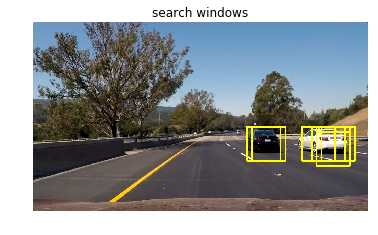

In [8]:
# t=time.time() # Start time
# for image_p in glob.glob('test_images/test*.jpg'):
image = cv2.imread('test_images/test6.jpg')
draw_image = np.copy(image)
windows = slide_window(image, x_range=[None, None], y_range=[400, 640], 
                       win_size=(128, 128), xy_overlap=(0.85, 0.85))

hot_windows = []
hot_windows += (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_ch=hog_ch, fspatial=fspatial, 
                    fhist=fhist, fhog=fhog))                       
window_img = draw_boxes(draw_image, hot_windows, color=(0,255,255), thick=6)                    
show_img(window_img, 'search windows')
# print(round(time.time()-t, 2), 'seconds to process test images')

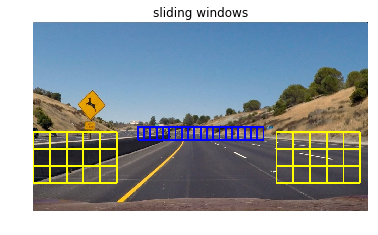

In [9]:
image = cv2.imread('test_images/test2.jpg')
windows = slide_window(image, x_range=[930, None], y_range=[420, 650], 
                    win_size=(128, 128), xy_overlap=(0.5, 0.5))

windows += slide_window(image, x_range=[0, 350], y_range=[420, 650], 
                    win_size=(128, 128), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(image, windows, color=(0,255,255), thick=6) 
windows = slide_window(image, x_range=[400, 880], y_range=[400, 470], 
                    win_size=(48, 48), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(window_img, windows, color=(255, 0, 0), thick=6)                    
show_img(window_img, 'sliding windows')

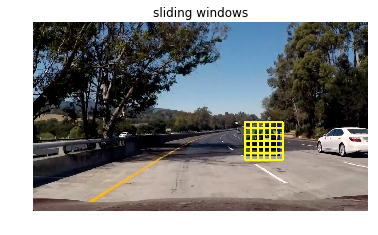

In [10]:

image = cv2.imread('test_images/test5.jpg')
track = (890, 460)
w_size = 80

windows = slide_window(image, x_range=[track[0] - w_size, track[0] + w_size], 
                       y_range=[track[1] - w_size, track[1] + w_size], 
                       win_size=(128, 128), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(image, windows, color=(255,0,0), thick=6)

windows = slide_window(image, x_range=[track[0] - w_size, track[0] + w_size], 
                       y_range=[track[1] - w_size, track[1] + w_size], 
                       win_size=(48, 48), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(window_img, windows, color=(0,255,255), thick=6)  

show_img(window_img, 'sliding windows')

Step 4: Extracting features from Regions of Interest and feed the feature vector into classifier for detectioin

In [11]:
def locate_cars(img, ylim, xlim, scale, step=2):
    '''
    Compute spatial, color hist and hog features for each image, agggrate the features
    and return positive box locations for car detections
    '''
    boxes = []
    
    y0,y1 = list(map(int,ylim))
    x0,x1 = list(map(int,xlim))
    
    roi = img[y0:y1, x0: x1,:]
    
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2LUV)
    roi = cv2.resize(roi, (int(roi.shape[1]/scale), int(roi.shape[0]/scale)))       

    ch1, ch2, ch3 = roi[:,:,0], roi[:,:,1], roi[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    n_blocks = (window // pix_per_cell) -1
    
    # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - n_blocks) // step
    nysteps = (nyblocks - n_blocks) // step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feat_vec=False)
    
    for xi in range(nxsteps):
        for yi in range(nysteps):
            ypos = yi*step
            xpos = xi*step
        
            # Extract HOG for this patch
            hog = hog1[ypos:ypos+n_blocks, xpos:xpos+n_blocks].ravel() 
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            # Extract the image patch
            patch = roi[ytop:ytop+window, xleft:xleft+window]
            # Get color features
            spatial = bin_spatial(patch)
            hist = color_hist(patch)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial, hist, hog)).reshape(1, -1))        
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xmin = int(xleft*scale + x0)
                ymin = int(ytop*scale + y0)
                win_dim = int(window*scale)
                boxes.append(((xmin, ymin),(xmin + win_dim, ymin + win_dim)))
    return boxes

A useful list of helper functions

In [12]:
track_list = []
Y_MIN = 440

def add_heat(heatmap, box_list):
    '''
    Add bounding boxes to the heatmap
    '''
    # Iterate through list of boxes
    for box in box_list:
        # Add += 1 for all pixels inside each box
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap 
    

def smooth(a, b, alpha=0.75): 
    '''
    Smooth the car boxes
    '''
    return a*alpha + (1.0-alpha)*b


def distance(x, y): 
    '''
    Distance beetween two points
    '''
    return np.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)


def track_to_box(p): 
    '''
    Create box coordinates out of its center and span
    '''
    p = list(map(int, p))
    return ((p[0]-p[2], p[1]-p[3]), (p[0]+p[2], p[1]+p[3]))


def draw_labeled_boxes(labels):
    '''
    Get final car detections from labels from the heatmap
    '''
    global track_list
    tracked_boxes = []
    for car_number in range(1, labels[1]+1):
        
        # Find pixels with each car_number label value
        non_zero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nz_y = np.array(non_zero[0])
        nz_x = np.array(non_zero[1])
        
        # Define a bounding box based on min/max x and y
        box = ((np.min(nz_x), np.min(nz_y)), (np.max(nz_x), np.max(nz_y)))

        size_x = (box[1][0]-box[0][0])/2.0 #Size of the found box
        size_y = (box[1][1]-box[0][1])/2.0
        
        size_m = (size_x + size_y)/2
        
        x = size_x+box[0][0]
        y = size_y+box[0][1]
        
        # Best rectangle aspect ratio for the box 
        aspect_ratio = (y-Y_MIN)/130.0+1.2 
        
        if x>1050 or x<230: aspect_ratio *= 1.4
        aspect_ratio = max(aspect_ratio, size_x / size_y) # for several cars chunk
        
        b_y = np.sqrt(size_x * size_y / aspect_ratio)
        b_x = int(b_y * aspect_ratio)
        b_y = int(b_y)
        
        #If the rectangle on the road, coordinates estimated from a test image
        if x > (-3.049*y+1809): 
            tracked_boxes.append(np.array([x, y, b_x, b_y]))
            if len(track_list) > 0:
                dist = []
                track_last = tracked_boxes[-1]
                
                for track in track_list:
                    dist.append(distance(track, track_last))
                min_d = min(dist)
                
                if min_d < 32:
                    ind = dist.index(min_d)
                    tracked_boxes[-1] = smooth(track_list[ind], tracked_boxes[-1])
                    
    track_list = tracked_boxes
    boxes = []
    for track in tracked_boxes:
        boxes.append(track_to_box(track))
    return boxes

Step 6: The main pipeline for processing each video frame

In [13]:
prev_heat = np.zeros((720, 1280)) # Store prev heat image
prev_boxes = [] # Store prev car boxes
iframe = 0 # Frame counter

def process_image(img, lane = False, video = True, show = False):
    '''
    Main function for processing videos frames 
    Draw rectangles on frames where cars are detected
    '''
    global prev_heat, prev_boxes, iframe
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    if (video and iframe%2==0) or not video: # Skip every second video frame
        
        boxes = []
        boxes =  locate_cars(img, ylim=(400,650), xlim=(950,1280), scale=2.0)
        boxes += locate_cars(img, ylim=(400,500), xlim=(950,1280), scale=1.5)
        boxes += locate_cars(img, ylim=(400,650), xlim=(0,330), scale=2.0)
        boxes += locate_cars(img, ylim=(400,500), xlim=(0,330), scale=1.5)
        boxes += locate_cars(img, ylim=(400,460), xlim=(330,950), scale=0.75, step=3)
        
        for track in track_list:
            y_loc = track[1] + track[3]
            lane_w = (y_loc*2.841-1170.0)/3.0

            lane_w = max(lane_w, 96)
            lane_w = max(lane_w, track[2])
            
            x1 = int(track[0] - lane_w)
            x2 = int(track[0] + lane_w)
            
            track[1] = max(track[1], Y_MIN)
                
            lane_h = lane_w/1.2
            y1 = int(track[1] - lane_h)
            y2 = int(track[1] + lane_h)

            x1 = max(x1, 0)
            x2 = min(x2, 1280)
            y1 = max(y1, Y_MIN-40)
            y2 = min(y2, 720)
                
            size_sq = lane_w / (0.015*lane_w + 0.3)
            c = size_sq / 64.0
            
            # Apply multi scale image windows 
            boxes += locate_cars(img, ylim=(y1,y2), xlim=(x1,x2), scale=c)
            boxes += locate_cars(img, ylim=(y1,y2), xlim=(x1,x2), scale=c*1.25)
            boxes += locate_cars(img, ylim=(y1,y2), xlim=(x1,x2), scale=c*1.5)
            boxes += locate_cars(img, ylim=(y1,y2), xlim=(x1,x2), scale=c*1.75)
            if show:
                cv2.rectangle(img, (x1, y1), (x2, y2), color=(0,255,0), thickness=3)
                
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        heat = add_heat(heat, boxes)
        cur_heat = prev_heat + heat
        prev_heat = heat
        
        # Apply threshold to help remove false positives
        heat = cur_heat[cur_heat < 3] = 0 
        
        # Visualize the heatmap when displaying    
        heatmap = np.clip(cur_heat, 0, 255)
        
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        cars_boxes = draw_labeled_boxes(labels)
        prev_boxes = cars_boxes
        
    else:
        cars_boxes = prev_boxes

            
    img_boxes = draw_boxes(np.copy(img), cars_boxes, color=(0,255,255), thick=6)
    if show:
        img_boxes = draw_boxes(imp, boxes, color=(0,255,255), thick=2)
        for track in track_list:
            cv2.circle(img_boxes, (int(track[0]), int(track[1])), 5, color=(255,0,255), thickness=4)
            
    iframe += 1
    return  cv2.cvtColor(img_boxes, cv2.COLOR_BGR2RGB)

Step 7: Generate the video output

In [14]:
from moviepy.editor import VideoFileClip
iframe = 0

output_file = 'project_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video project_result.mp4
[MoviePy] Writing video project_result.mp4


100%|█████████▉| 1260/1261 [02:45<00:00,  9.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_result.mp4 

CPU times: user 4min 12s, sys: 1.63 s, total: 4min 13s
Wall time: 2min 46s
